### Problem 1 – Classification tree (35%)
The dataset ‘titanic.csv’ included in the assignment contains information about passengers onboard RMS Titanic on its maiden voyage. Your goal is to build a classification tree to predict which passengers survived based on the provided information.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
titanic = pd.read_csv('titanic.csv')
print(titanic.shape)
titanic.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's first go into what the columns of the Titanic Dataset are:
- PassengerID: Unique ID of the passenger
- Survived: 0 is if they didn't, 1 is if they did
- pclass: ticket class, so first, second, or third
- Name: Passenger Name
- Sex: sex of passenger
- Age: age of passenger
- SibSp: number of siblings/spouses aboard
- Parch: number of parents/children aboard
- Ticket: ticket number
- Fare: passenger fare
- Cabin: cabin number
- Embarked: port of embarkation, so S for southamptom, q for queenstown, and c for cherbourg

Lets reference Kaggle for this! https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset

Wow! Inspecting the data above shows us that some processing of the dataset is in order. Things like name doesn't seem like a good predictor of survival, and we thus need to adapt some features.

In [3]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
#looking at the kaggle reference, we see that they convert some data
original_dat = titanic.copy()

titanic['Has_Cabin'] = titanic["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [5]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in [titanic]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [6]:
# Create new feature IsAlone from FamilySize
for dataset in [titanic]:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [7]:
# Remove all NULLS in the Embarked column
for dataset in [titanic]:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in [titanic]:
    dataset['Fare'] = dataset['Fare'].fillna(titanic['Fare'].median())

In [8]:
# Remove all NULLS in the Age column
for dataset in [titanic]:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [9]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [10]:
for dataset in [titanic]:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in [titanic]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [11]:
for dataset in [titanic]:
    #map sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [12]:
#now lets drop the unecessary columns
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
titanic = titanic.drop(drop_elements, axis = 1)

In [13]:
print("hooray! now our data is clean and only has numerical values.")
titanic.head()

hooray! now our data is clean and only has numerical values.


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [14]:
titanic[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [15]:
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [16]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_dat.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

##### 15% credit. Grow a classification tree on the entire training set.
Visualize the tree (e.g., as in L11, slide 24), discuss which variables are selected at each split and explain the meaning of those decisions, analyze node purity, etc. This part of the exercise is open-ended. Explore the model and see what you can find out.
- https://www.youtube.com/watch?v=o8GE4s-jcdg
- https://plainenglish.io/blog/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda

In [17]:
target = titanic['Survived'].values
features = titanic.drop(['Survived'], axis=1).values

In [18]:
clf = tree.DecisionTreeClassifier(ccp_alpha = 0.005)
# clf = tree.DecisionTreeClassifier(max_depth=3)

clf = clf.fit(features, target)

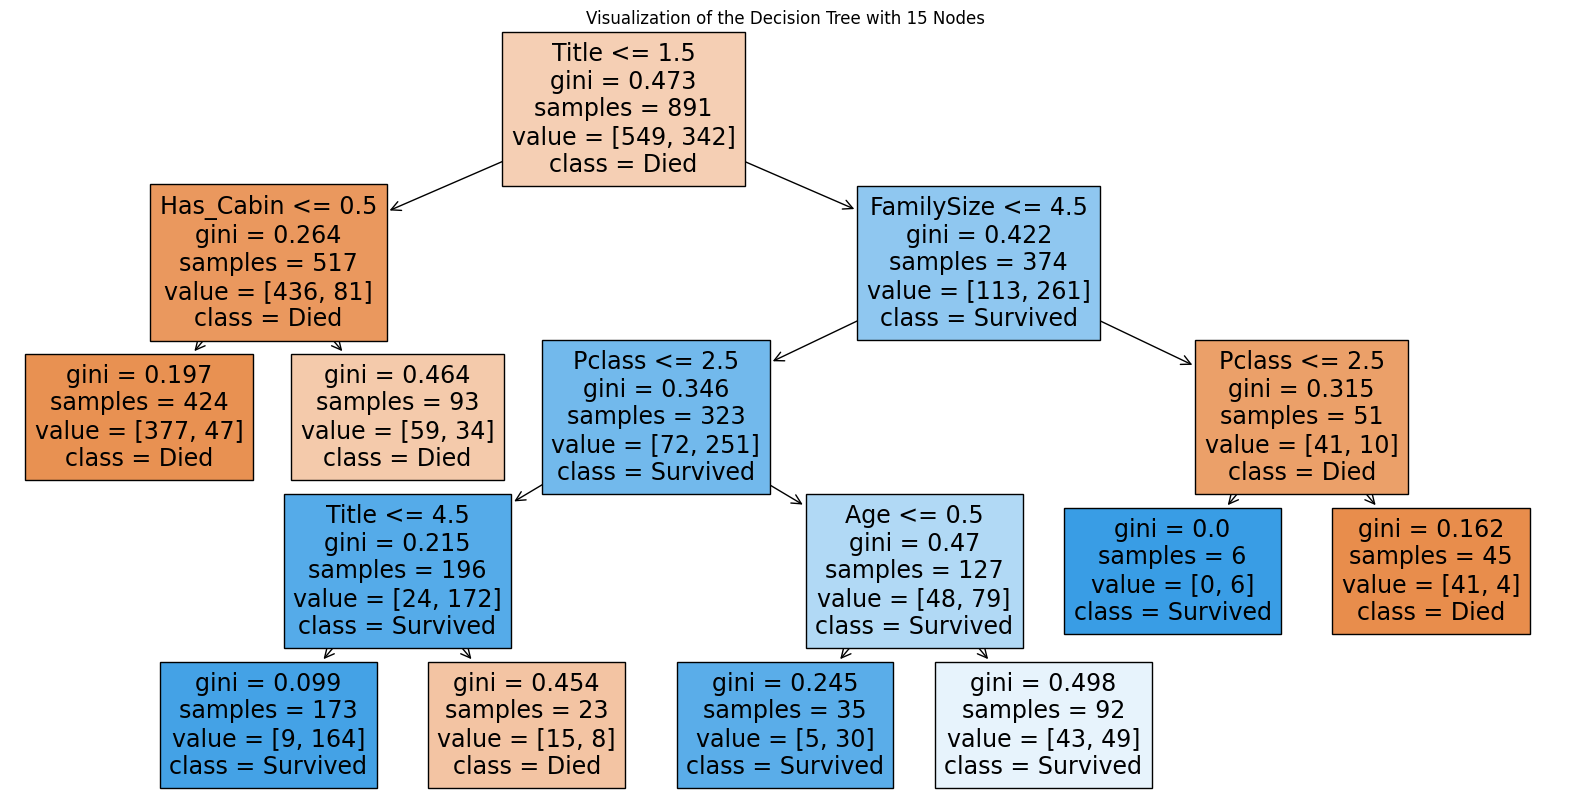

In [19]:
plt.figure(figsize=(20,10))
feat = ['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Has_Cabin',
       'FamilySize', 'IsAlone', 'Title']
tree.plot_tree(clf, class_names=["Died", "Survived"], feature_names=feat, filled=True)
plt.title("Visualization of the Decision Tree with 15 Nodes")
plt.show()

In [20]:
#unpruned tree
clf0 = tree.DecisionTreeClassifier()
clf0 = clf0.fit(features, target)

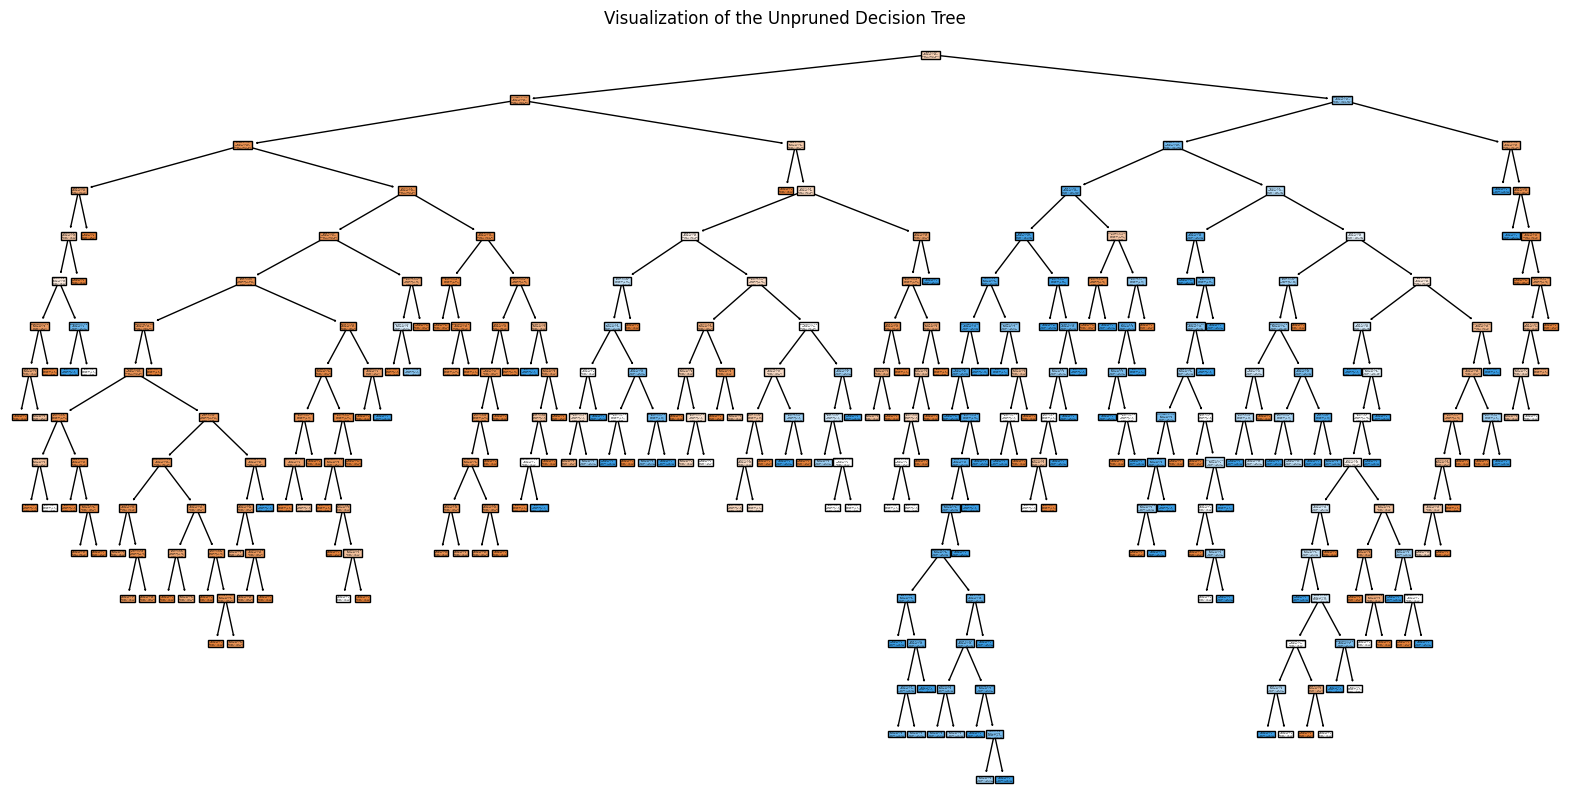

In [21]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf0, class_names=["Died", "Survived"], feature_names=feat, filled=True)
plt.title("Visualization of the Unpruned Decision Tree")
plt.show()

#### 10% credit. Repeat the previous process, but this time using different values for the pruning hyperparameter 𝛼 (see L11, slide 20).
 Analyze and discuss the results.

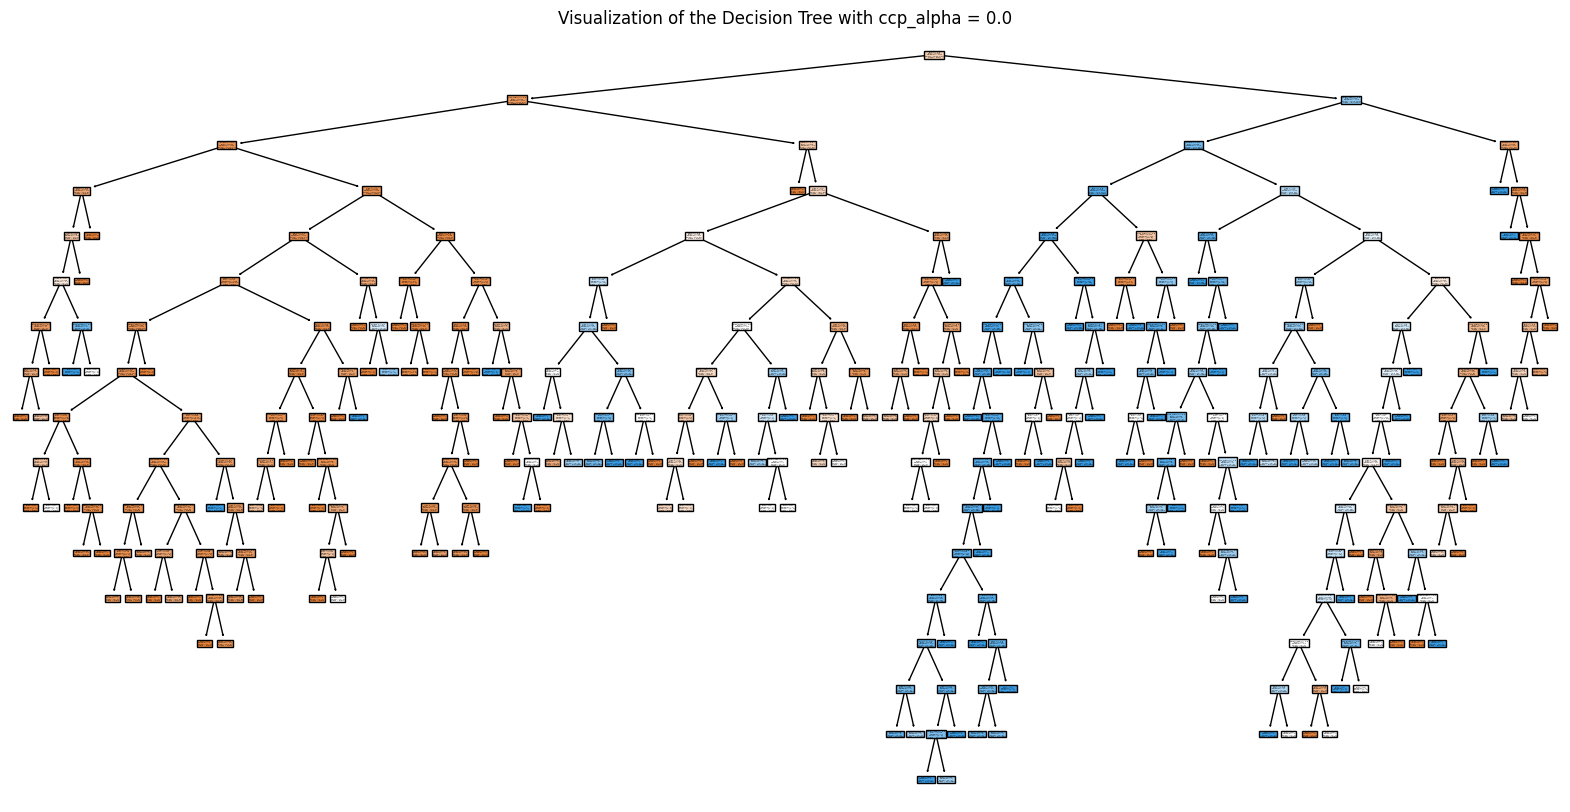

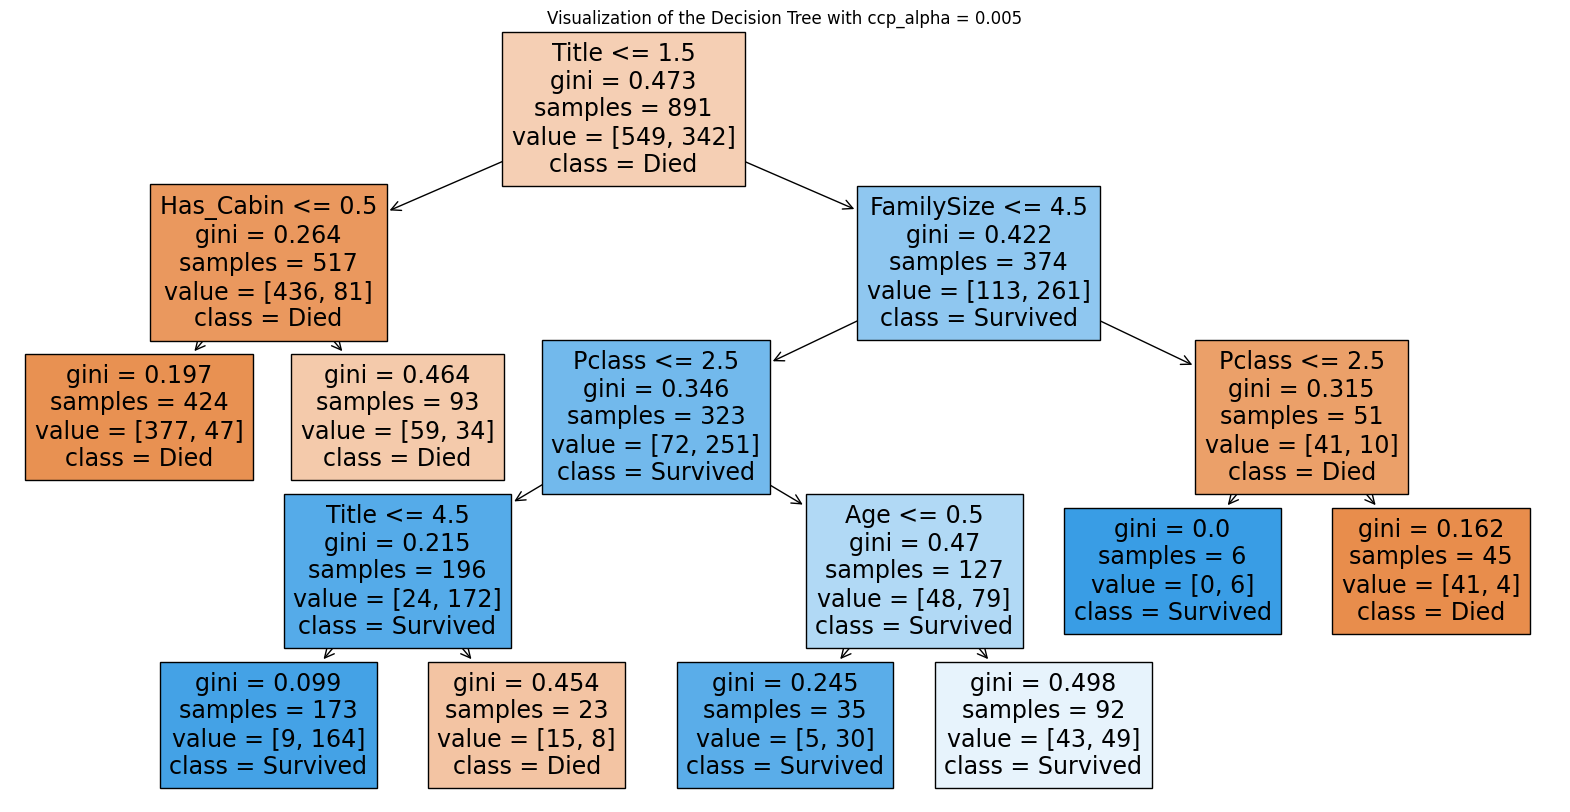

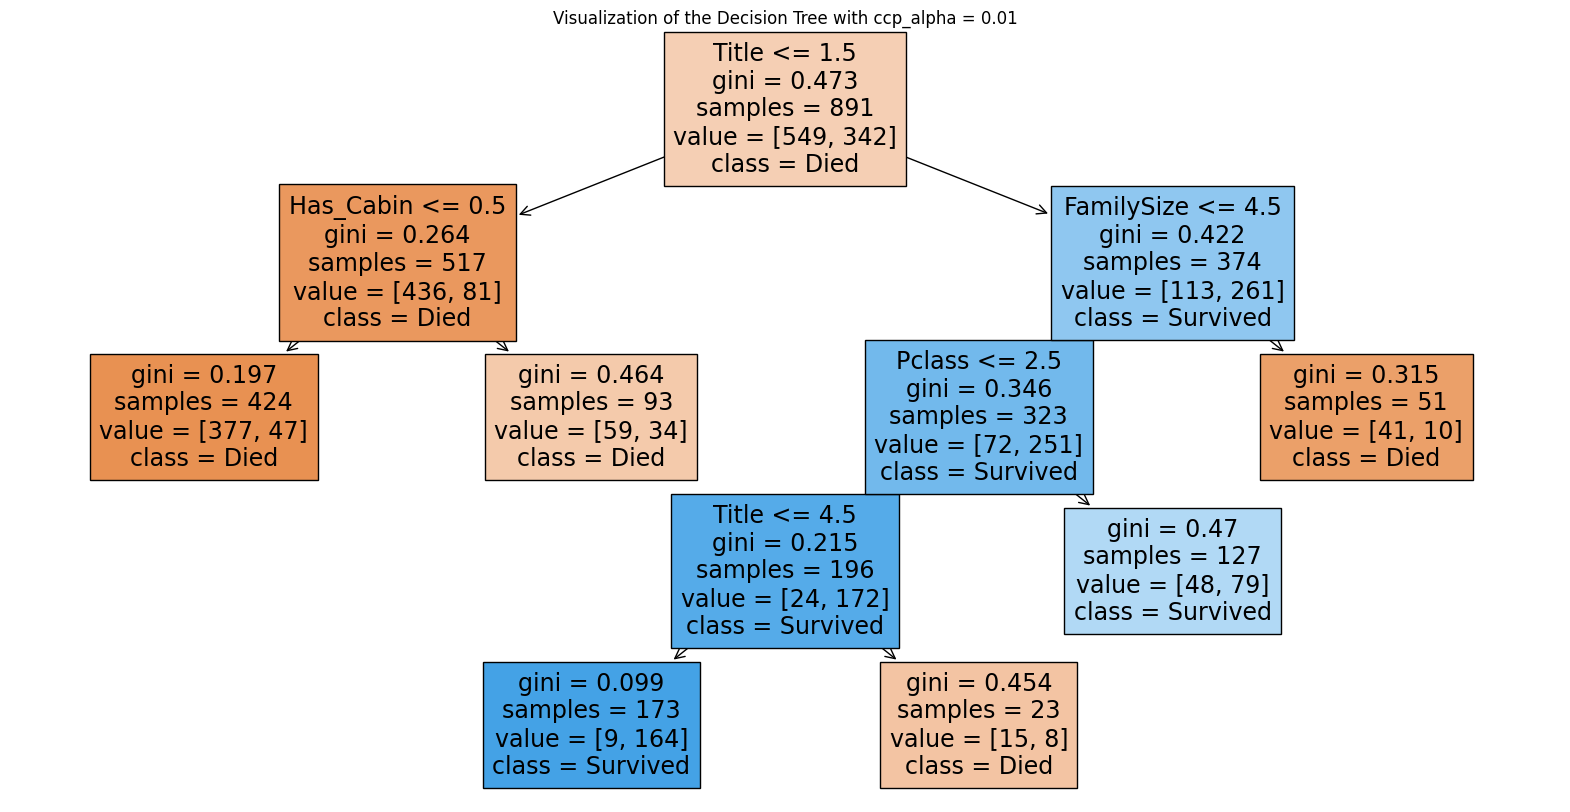

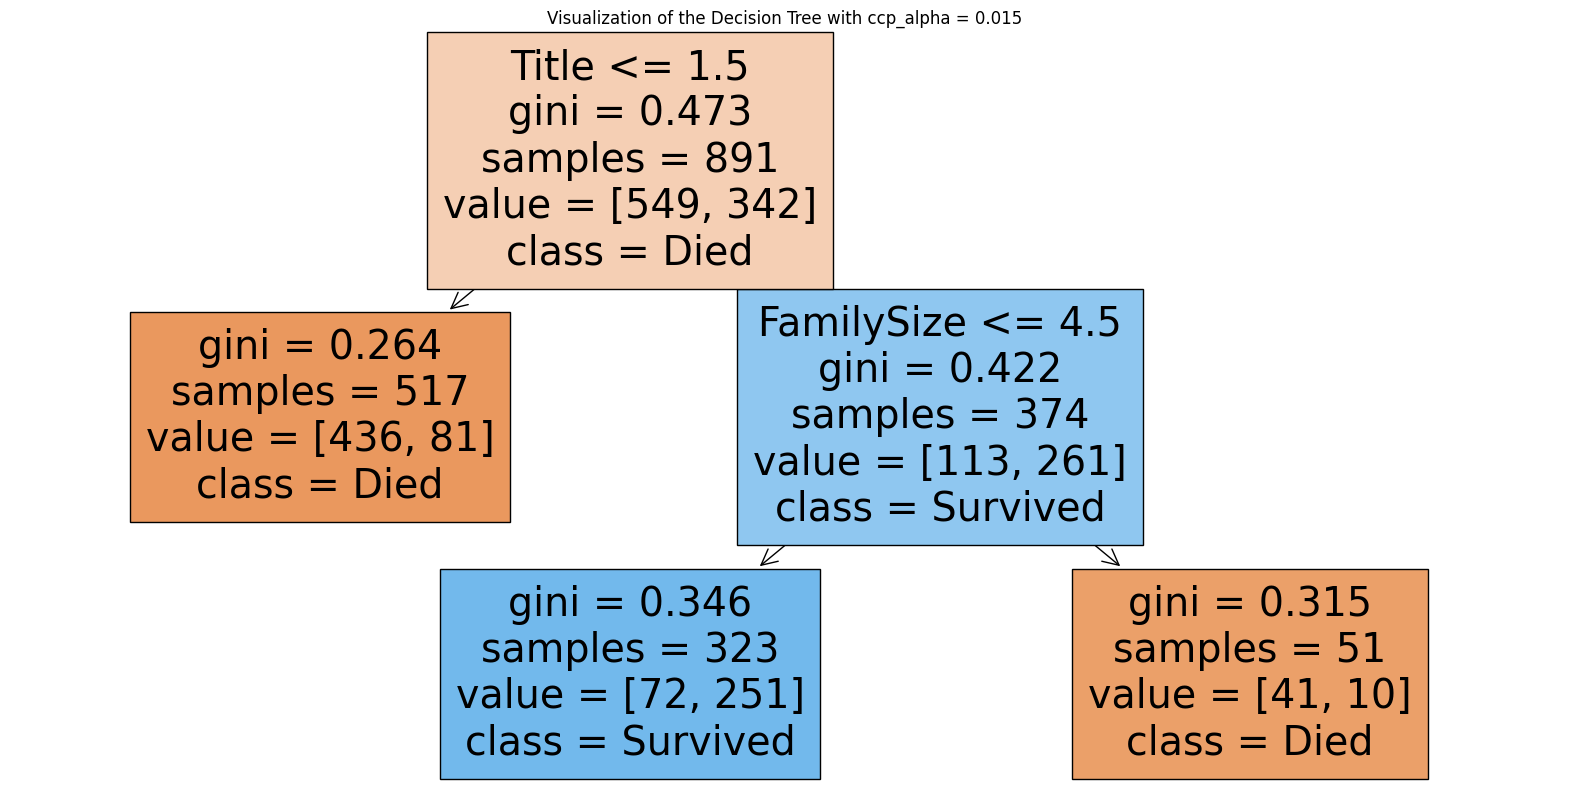

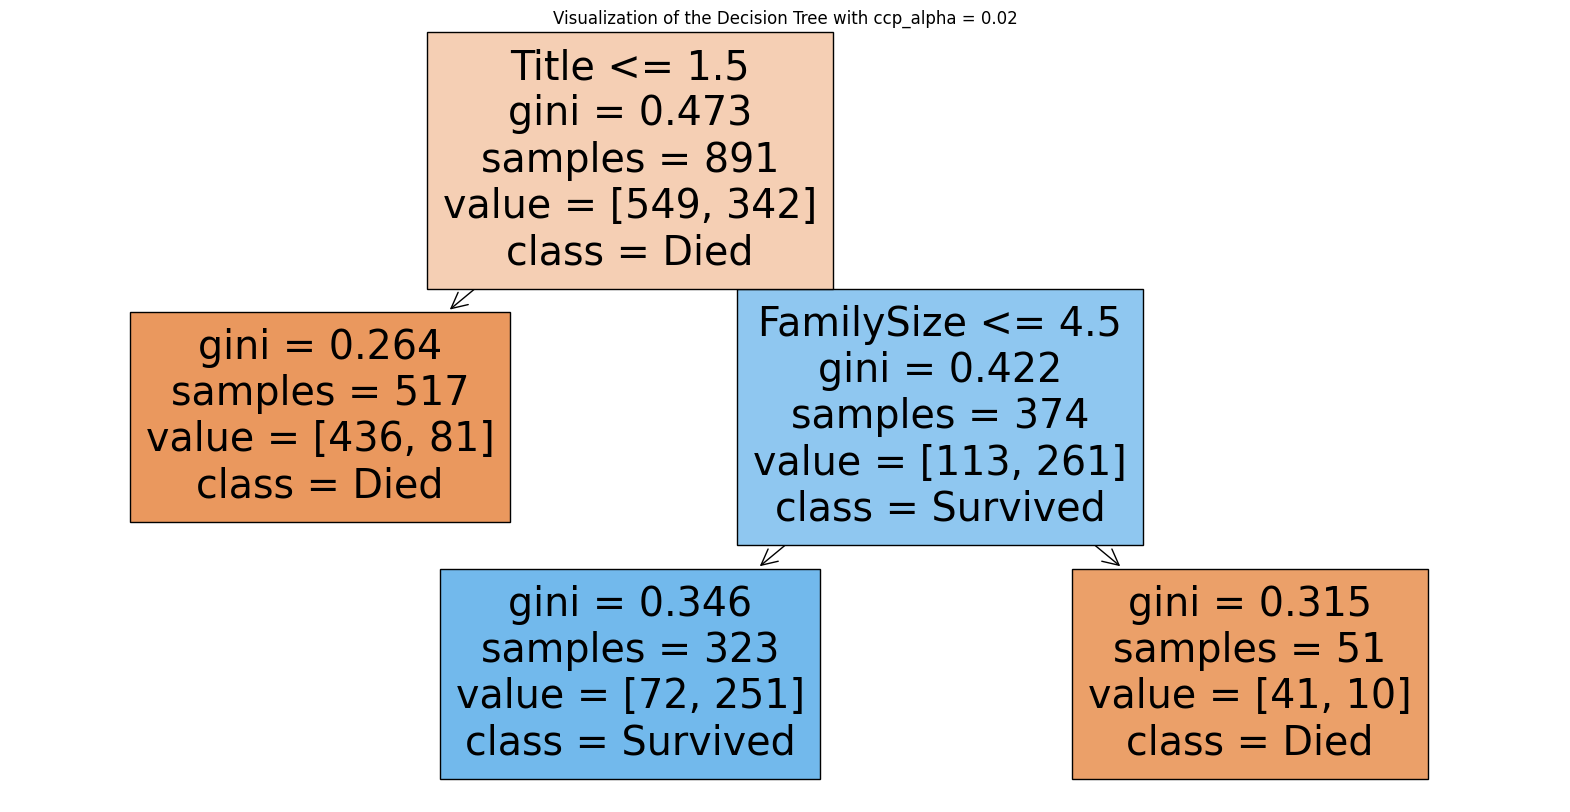

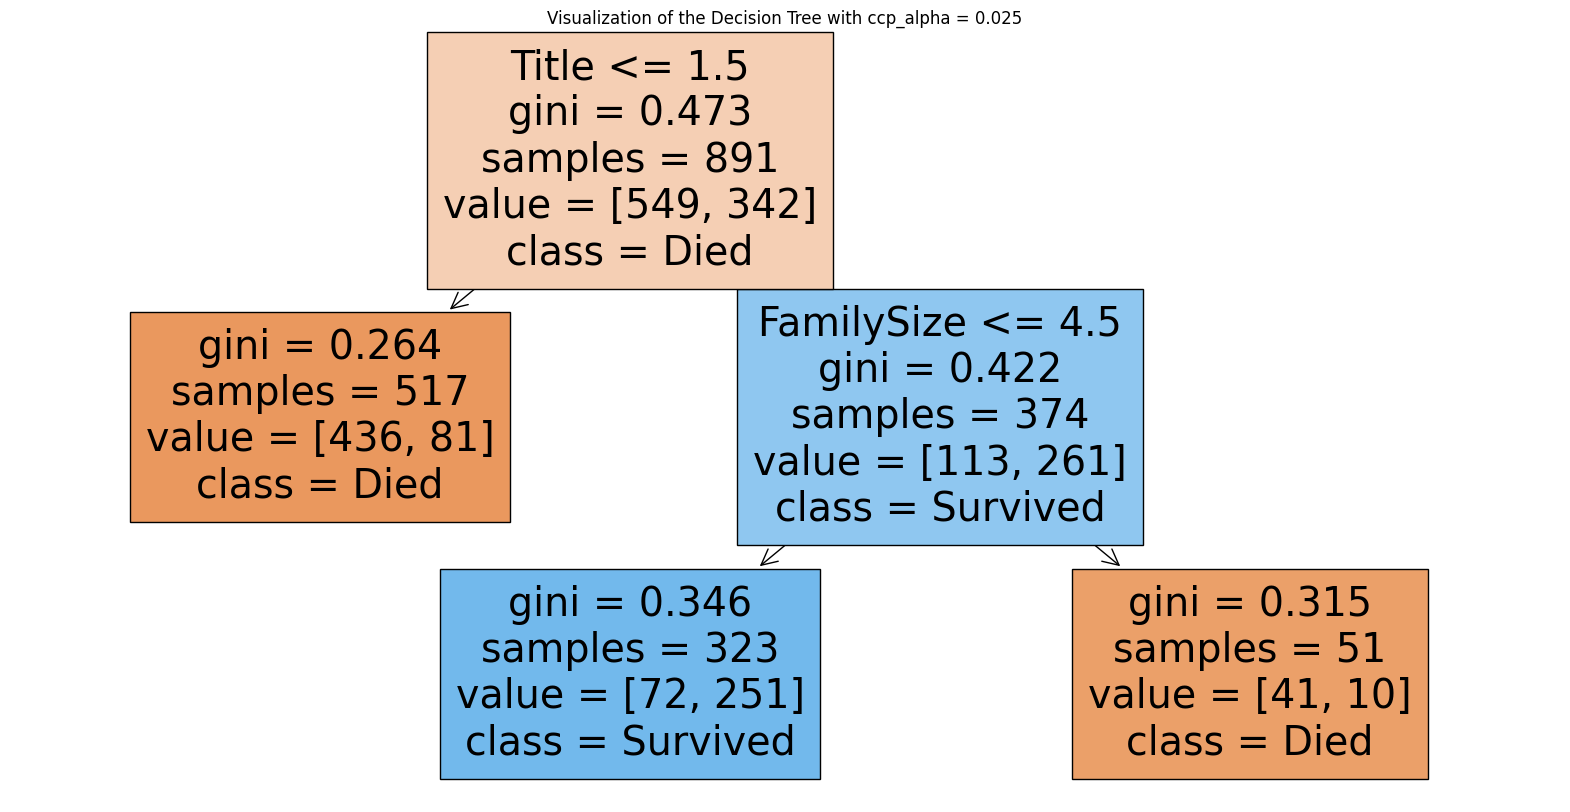

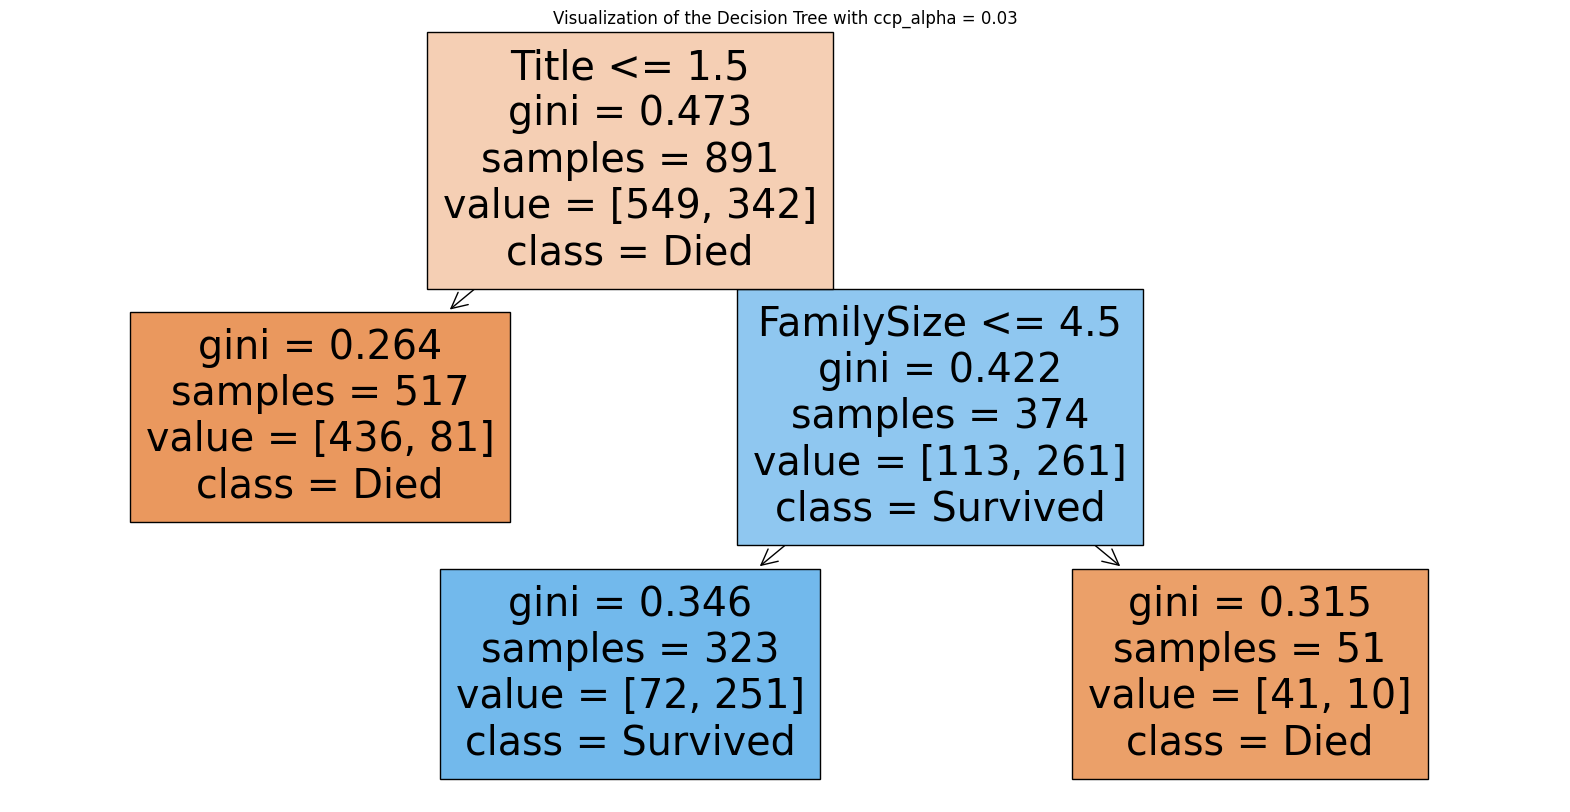

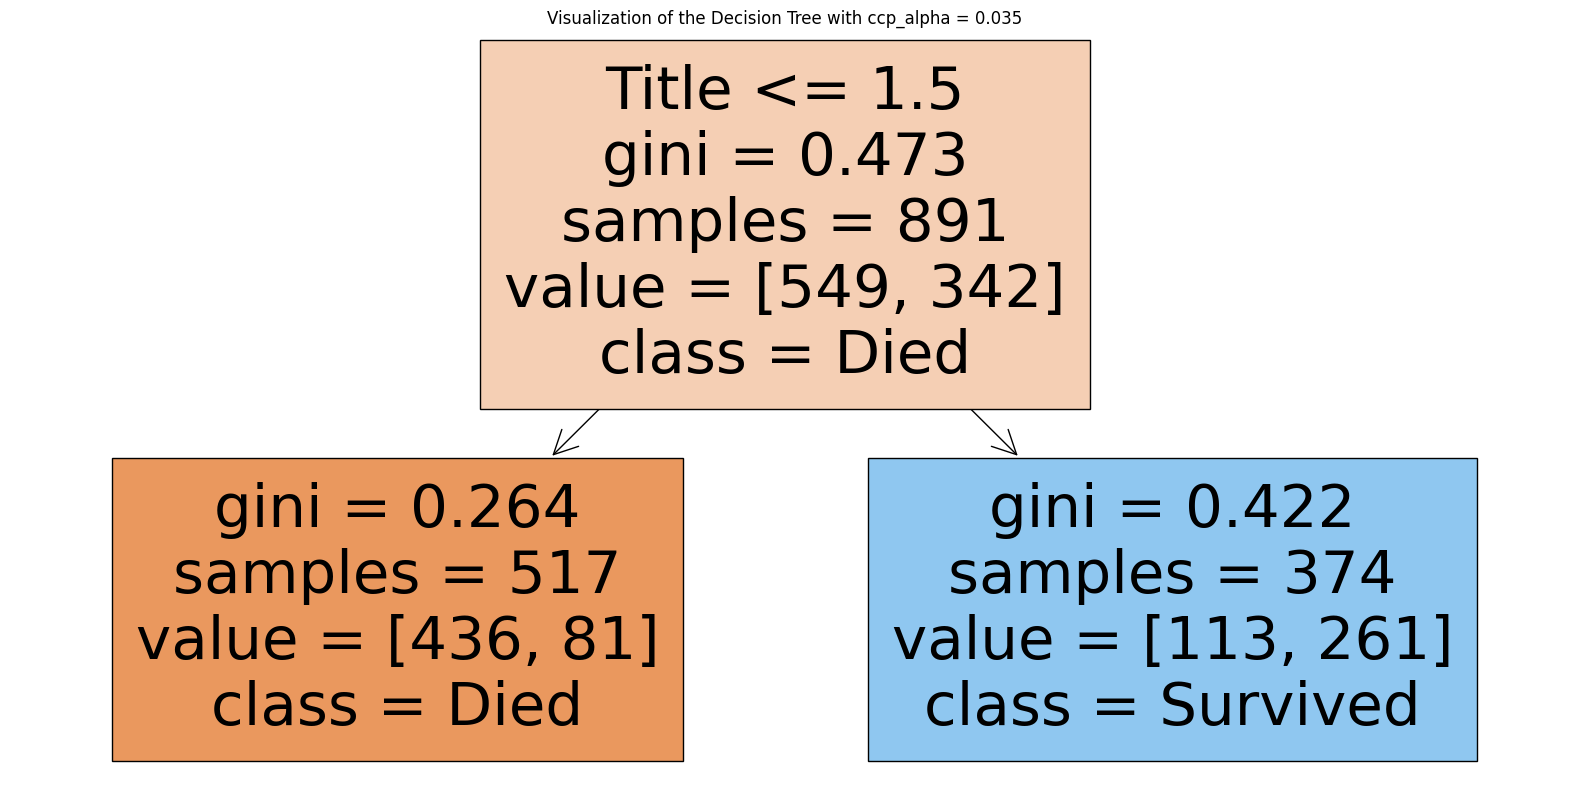

In [22]:
# different alphas
alphas  = np.arange(0, 0.04, 0.005)

# train_scores = []
# test_scores = []
for alpha in alphas:
    # split data into train and test
    
    clf = tree.DecisionTreeClassifier(ccp_alpha = alpha)
    clf.fit(features, target)
    # train_score = clf.score(features, target)
    # test_score = cross_val_score(clf, features, target, cv = 10).mean()
    # train_scores.append(train_score)
    # test_scores.append(test_score)

    #display the tree
    plt.figure(figsize=(20,10))
    tree.plot_tree(clf, class_names=["Died", "Survived"], feature_names=feat, filled=True)
    plt.title("Visualization of the Decision Tree with ccp_alpha = " + str(alpha))
    plt.show()
    

#### 10% credit. Estimate classification performance using 10-fold cross validation.
 Discuss which pruning criteria you used and how it impacted classification performance on unseen data.

In [23]:
#now lets make box plots for all the alphas and see how they compare
cross_val_scores = []
for alpha in alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha = alpha)
    
    scores = cross_val_score(clf, features, target, cv = 10)
    cross_val_scores.append(scores)
    

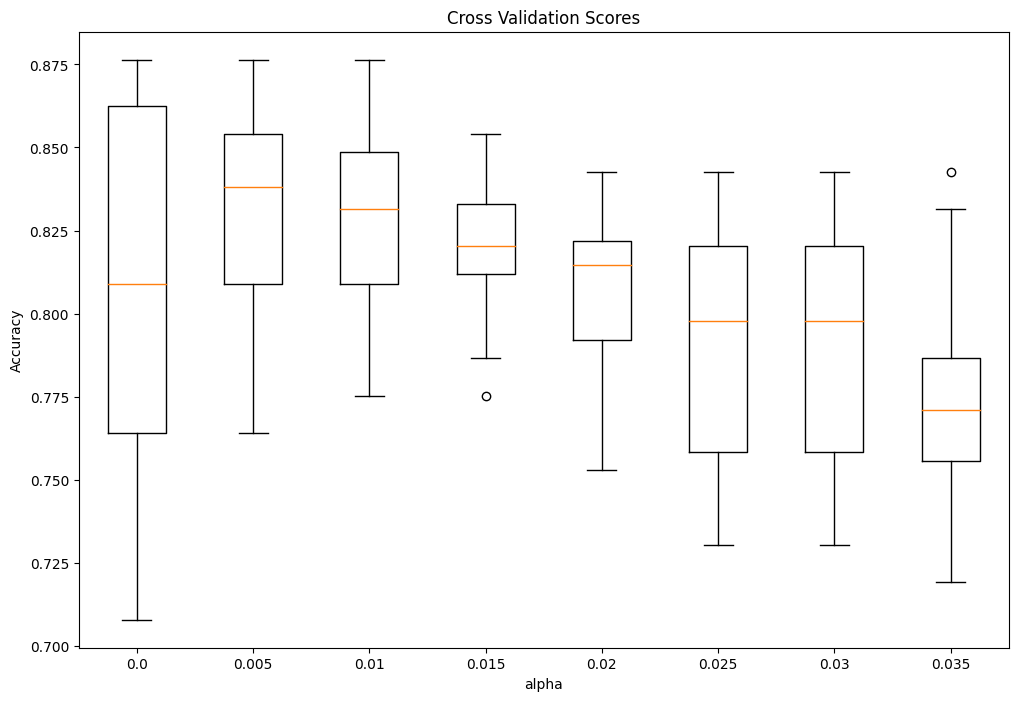

In [24]:
#display boxplots for all alphas
plt.figure(figsize = (12, 8))
plt.boxplot(cross_val_scores)
plt.xlabel('alpha')
plt.xticks(np.arange(len(alphas))+1, alphas)
plt.ylabel('Accuracy')
plt.title('Cross Validation Scores')

plt.show()


In [25]:
#based on the cross validation scores, choose the best alpha
#take the mean of this cross_val_scores
mean_cross_val_scores = [np.mean(score) for score in cross_val_scores]

best_alpha = alphas[np.argmax(mean_cross_val_scores)]
print('best alpha: ', best_alpha)


best alpha:  0.005


In [28]:
#now lets interpret significance of the features
import scipy.stats as stats
f_value, p_value = stats.f_oneway(*cross_val_scores)

print("The p value is ", p_value)

if p_value < 0.05:
    print("There is significant difference between classification performances of the k values")
else:
    print("There is not a significant difference between classification performances of the k values")


The p value is  0.03607430381753651
There is significant difference between classification performances of the k values


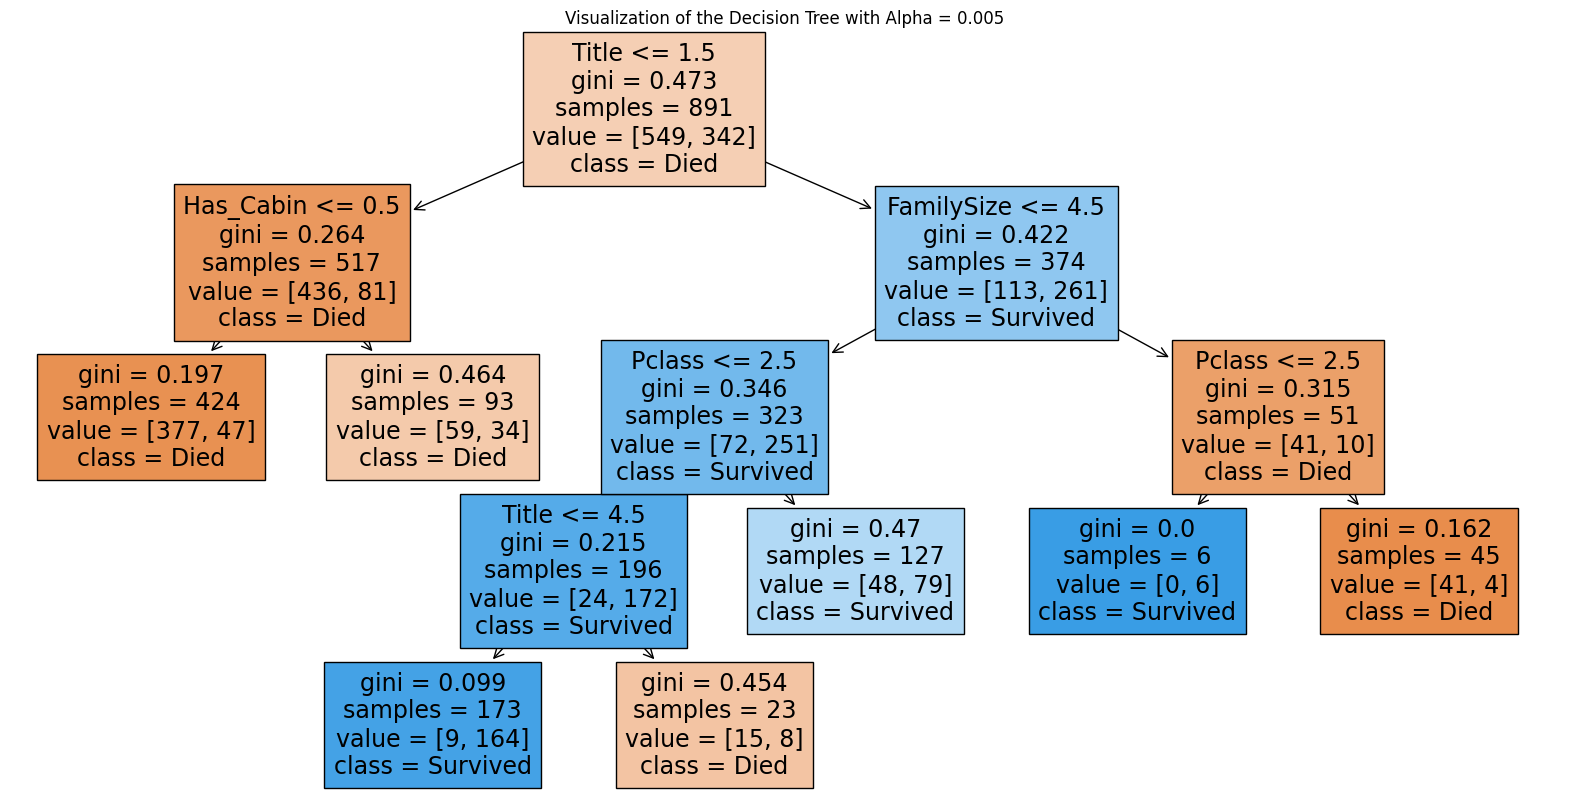

In [ ]:
#the best tree
clf = tree.DecisionTreeClassifier(ccp_alpha = best_alpha)
clf.fit(features, target)

plt.figure(figsize=(20,10))
tree.plot_tree(clf, class_names=["Died", "Survived"], feature_names=feat, filled=True)
plt.title("Visualization of the Decision Tree with Alpha = {}".format(best_alpha))
plt.show()
